##0. Загружаем данные, импортим библиотеки

In [ ]:
!wget http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip
!unzip ut-zap50k-images.zip
! pip install hnswlib

In [6]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from skimage import io
import re
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm
from IPython.display import clear_output
import hnswlib
import numpy as np
from collections import defaultdict
import random
import os

#0. Определяем классы с датасетами и моделью

In [7]:
def get_label(img_path, meta):
    crop = re.search(r"/[0-9]+.[0-9]+", img_path).group(0)[1:]
    code = crop.replace('.', '-')
    label = "Other"
    try:
        label = ", ".join(np.array(meta.loc[meta['CID'] == code])[0][1:3])
    except:
        print("Error in label at", img_path, code,
              np.array(meta.loc[meta['CID'] == code]))
    return label


class ShoesDataset(Dataset):
    def __init__(self, csv_path, img_folder):
        """
        Args:
            csv_path (string): Csv file with labels.
            img_paths (list): List of all images' path names.
            transform (callable): Optional transform to be applied
                on a sample.
        """
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        folder = img_folder
        classes = {}
        numofpics = defaultdict(int)
        img_paths = []
        count = 0

        for cat in os.listdir(folder):
            folder1 = folder + "/" + cat
            if cat == '.DS_Store':
                continue
            for subcat in os.listdir(folder1):
                folder2 = folder1 + "/" + subcat
                classes[cat + ", " + subcat] = count
                classes[count] = cat + ", " + subcat
                count += 1
                if subcat == '.DS_Store':
                    continue
                for brand in os.listdir(folder2):
                    folder3 = folder2 + "/" + brand
                    if brand == '.DS_Store':
                        continue
                    for pic in os.listdir(folder3):
                        if random.randint(1, 100) > 50:
                            continue
                        numofpics[cat + ", " + subcat] += 1
                        img_paths.append(folder3 + "/" + pic)

        temp = numofpics.copy()
        temp["Other"] = 0
        for key, val in numofpics.items():
            if val < 1000:
                temp["Other"] += val
                temp.pop(key)
                classes.pop(key)
                classes[key] = 22

        classes[22] = "Other"
        classes["Other"] = 22
        numofpics = temp.copy()

        id2label = {x: i for i, x in
                    enumerate(classes[x] for x in numofpics.keys())}
        print("loaded img_paths")

        self.csv = pd.read_csv(csv_path)
        self.transform = transform
        tmpi = []
        self.labels = []
        for i in tqdm.notebook.tqdm(img_paths):
            img = io.imread(i)
            if img.shape != (102, 136, 3):
                continue
            self.labels.append(id2label[classes[get_label(i, self.csv)]])
            tmpi.append(transform(img))

        self.imgs = torch.stack(tmpi)
        print("loaded dataset")
        self.img_paths = img_paths

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return [self.imgs[idx], self.labels[idx]]

In [8]:
class AE3(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.encoder_seq = nn.Sequential()

        self.encoder_seq.add_module('conv1',
                                    nn.Conv2d(in_channels=3, out_channels=6,
                                              kernel_size=3,
                                              padding=1))
        self.encoder_seq.add_module('bn_conv1', nn.BatchNorm2d(6))
        self.encoder_seq.add_module('conv1_relu', nn.ReLU())
        self.encoder_seq.add_module('pool1',
                                    nn.MaxPool2d(kernel_size=3, stride=3))

        self.encoder_seq.add_module('conv1-5',
                                    nn.Conv2d(in_channels=6, out_channels=6,
                                              kernel_size=2, padding=1))
        self.encoder_seq.add_module('conv1-5_relu', nn.ReLU())

        self.encoder_seq.add_module('conv2',
                                    nn.Conv2d(in_channels=6, out_channels=10,
                                              kernel_size=3,
                                              padding=1))
        self.encoder_seq.add_module('conv2_relu', nn.ReLU())
        self.encoder_seq.add_module('pool2',
                                    nn.MaxPool2d(kernel_size=3, stride=3,
                                                 padding=0))

        self.encoder_seq.add_module('conv2-5',
                                    nn.Conv2d(in_channels=10, out_channels=10,
                                              kernel_size=2, padding=1))
        self.encoder_seq.add_module('conv2-5_relu', nn.ReLU())

        self.encoder_seq.add_module('conv3',
                                    nn.Conv2d(in_channels=10, out_channels=16,
                                              kernel_size=3,
                                              padding=1))
        self.encoder_seq.add_module('bn_conv2', nn.BatchNorm2d(16))
        self.encoder_seq.add_module('conv3_relu', nn.ReLU())
        self.encoder_seq.add_module('pool3',
                                    nn.MaxPool2d(kernel_size=2, stride=2,
                                                 padding=0))

        self.decoder_seq = nn.Sequential()

        self.decoder_seq.add_module('deconv1',
                                    nn.ConvTranspose2d(in_channels=16,
                                                       out_channels=10,
                                                       kernel_size=2, stride=2,
                                                       padding=0))
        self.decoder_seq.add_module('deconv1_relu', nn.ReLU())

        self.decoder_seq.add_module('deconv1-5',
                                    nn.ConvTranspose2d(in_channels=10,
                                                       out_channels=10,
                                                       kernel_size=2,
                                                       padding=0))
        self.decoder_seq.add_module('deconv1-5_relu', nn.ReLU())
        self.decoder_seq.add_module('bn_deconv1', nn.BatchNorm2d(10))

        self.decoder_seq.add_module('deconv2',
                                    nn.ConvTranspose2d(in_channels=10,
                                                       out_channels=6,
                                                       kernel_size=3, stride=3,
                                                       padding=1))  # convolution
        self.decoder_seq.add_module('deconv2_relu', nn.ReLU())

        self.decoder_seq.add_module('deconv2-5',
                                    nn.ConvTranspose2d(in_channels=6,
                                                       out_channels=6,
                                                       kernel_size=2,
                                                       padding=2))
        self.decoder_seq.add_module('deconv2-5_relu', nn.ReLU())
        self.decoder_seq.add_module('bn_deconv2', nn.BatchNorm2d(6))

        self.decoder_seq.add_module('deconv3', nn.ConvTranspose2d(in_channels=6,
                                                                  out_channels=3,
                                                                  kernel_size=3,
                                                                  stride=3,
                                                                  padding=(0,
                                                                           1)))
        
        
        self.alpha = nn.Parameter(torch.FloatTensor([1]))
        self.bias = nn.Parameter(torch.FloatTensor([0]))

    def encode(self, x):
        self.encoded = self.encoder_seq(x)
        return self.encoded

    def decode(self, x):
        self.decoded = self.decoder_seq(x) * self.alpha + self.bias
        return self.decoded

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [5]:
def knn_samples(csv_path, img_paths, model):
    """
        Input:
            csv_path (string): Csv file with labels.
            img_paths (list): List of all images' path names.
            model (torch.nn.Module): autoencoder
        Output:
            samples: array of encoded images
            labels: array of labels for samples
    """
    samples = []
    labels = []

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    csv = pd.read_csv(csv_path)

    for i in tqdm.notebook.tqdm(img_paths):
        img = io.imread(i)
        if img.shape != (102, 136, 3) or \
                i == "ut-zap50k-images/Boots/Mid-Calf/Primigi Kids/8022042.89.jpg":
            continue

        img = transform(img).reshape((1, 3, 102, 136))
        with torch.no_grad():
            img = model.encode(img.to('cuda'))

        samples.append(torch.flatten(img))
        labels.append(get_label(i, csv))

    for i in range(len(samples)):
        samples[i] = samples[i].to('cpu').numpy()

    samples = np.array(samples)

    print('loaded samples')
    return samples, labels, img_paths

In [6]:
def count_distances(samples, n_top):
    num_elements, dim = samples.shape

    data1 = samples[:num_elements // 2]
    data2 = samples[num_elements // 2:]

    p = hnswlib.Index(space='l2', dim=dim)
    p.init_index(max_elements=num_elements // 2, ef_construction=100, M=16)

    p.set_ef(10)

    p.set_num_threads(4)

    print("Adding first batch of %d elements" % (len(data1)))
    p.add_items(data1)

    labels, distances = p.knn_query(data1, k=n_top)
    print("Recall for the first batch:",
          np.mean(labels.reshape(-1) == np.arange(len(data1))), "\n")

    index_path = 'first_half.bin'
    print("Saving index to '%s'" % index_path)
    p.save_index(index_path)
    del p

    p = hnswlib.Index(space='l2', dim=dim)

    print("\nLoading index from 'first_half.bin'\n")

    p.load_index("first_half.bin", max_elements=num_elements)

    print("Adding the second batch of %d elements" % (len(data2)))
    p.add_items(data2)

    labels, distances = p.knn_query(samples, k=n_top)
    print("Recall for two batches:",
          np.mean(labels.reshape(-1) == np.arange(len(samples))), "\n")
    print('counted cnn')
    return labels, distances

In [7]:
from torchsummary import summary
model = AE3()
summary(model.cuda(), (3,136, 102))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 136, 102]             168
       BatchNorm2d-2          [-1, 6, 136, 102]              12
              ReLU-3          [-1, 6, 136, 102]               0
         MaxPool2d-4            [-1, 6, 45, 34]               0
            Conv2d-5            [-1, 6, 46, 35]             150
              ReLU-6            [-1, 6, 46, 35]               0
            Conv2d-7           [-1, 10, 46, 35]             550
              ReLU-8           [-1, 10, 46, 35]               0
         MaxPool2d-9           [-1, 10, 15, 11]               0
           Conv2d-10           [-1, 10, 16, 12]             410
             ReLU-11           [-1, 10, 16, 12]               0
           Conv2d-12           [-1, 16, 16, 12]           1,456
      BatchNorm2d-13           [-1, 16, 16, 12]              32
             ReLU-14           [-1, 16,

In [8]:
print(model)

AE3(
  (encoder_seq): Sequential(
    (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn_conv1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_relu): ReLU()
    (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv1-5): Conv2d(6, 6, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (conv1-5_relu): ReLU()
    (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_relu): ReLU()
    (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv2-5): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (conv2-5_relu): ReLU()
    (conv3): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn_conv2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3_relu): ReLU()
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

##1. Подгружаем данные

In [9]:
img_folder = 'ut-zap50k-images'
ds = ShoesDataset('meta-data.csv', img_folder)
if os.path.isfile('model.pt'):
  Model = torch.load('model.pt')

loaded img_paths


Error in label at ut-zap50k-images/Boots/Mid-Calf/Primigi Kids/8022042.89.jpg 8022042-89 []

loaded dataset


In [ ]:
if os.path.isfile('model.pt'):
  Model = torch.load('model.pt')
  samples, labels, img_paths = knn_samples('meta-data.csv', ds.img_paths, Model)
else:
  print('Model did not load')

##2. Обучаем модель (пропускаем шаг, если  модель загружена  в Model)

In [ ]:
model = AE3().cuda()

In [ ]:
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
trainset, testset = torch.utils.data.random_split(ds, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False, num_workers=2
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

count_loss = nn.MSELoss()

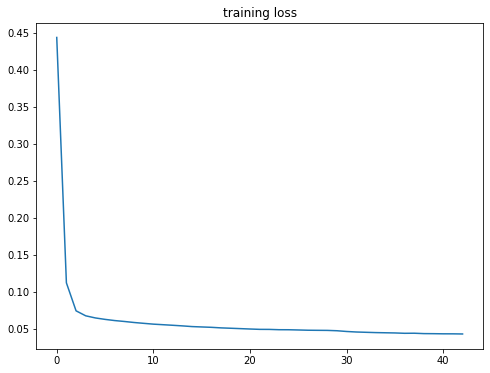

epoch : 43/500, loss = 0.042849
test loss: 0.044432301074266434 (updated 2 epochs ago)


KeyboardInterrupt: ignored

In [ ]:
epochs = 500
save = 25
test = 20
loss = []

for epoch in range(epochs):
    batchloss = 0
    model.train(True)
    for xbatch, _ in tqdm.notebook.tqdm(trainloader):  

        optimizer.zero_grad()
        outputs = model(xbatch.cuda())
        train_loss = count_loss(outputs.cuda(), xbatch.cuda())
        train_loss.backward()
        optimizer.step()
        
        batchloss += train_loss.item()
    

    loss.append(batchloss / len(trainloader))

    # save
    
    if epoch % save == 0:
      torch.save(model, f"model-{epoch / save}.pt")

    # test loss
    
    if epoch % test == 0:
      with torch.no_grad():
        model.train(False)
        batchloss = 0
        for testx, testy in testloader:
          testx = testx.to("cuda")

          outputs = model(testx)
          batchloss += count_loss(outputs, testx)
          
        testloss = batchloss / len(testloader)

    # display 

    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))

    fig, axs = plt.subplots(1, 1, figsize=(8, 6))
    clear_output(wait=True)
    axs.plot(loss)
    axs.set_title('training loss')
    plt.show()
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))
    print(f"test loss: {testloss} (updated {epoch % test} epochs ago)")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


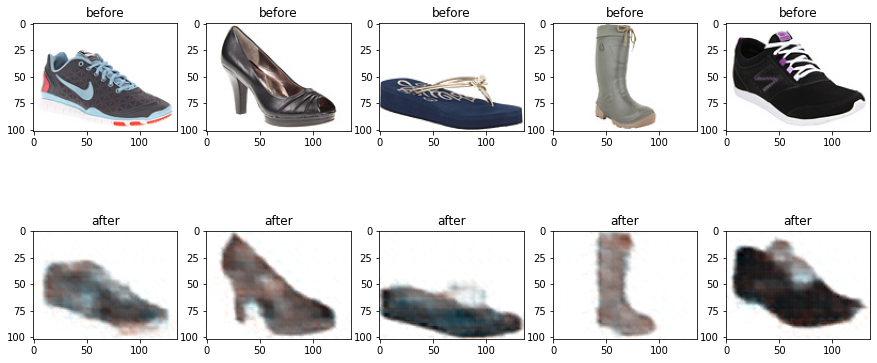

In [ ]:
examples = 5
model.eval()

with torch.no_grad():
  testx = next(iter(trainloader))[0][:examples].to("cuda")

  predicted = model(testx)
  fig, axs = plt.subplots(2, 5, figsize=(15, 7))

  for i in range(examples):
    
    axs[0][i].imshow(np.rot90(testx[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[0][i].set_title('before')
    axs[1][i].imshow(np.rot90(predicted[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[1][i].set_title('after')
  plt.show()

In [ ]:
Model = model
Model.eval()
samples, labels, img_paths = knn_samples('meta-data.csv', ds.img_paths, Model)


loaded samples


##3. Генерируем нормальный вектор и смотрим на ближайшие

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



decoded version of original example


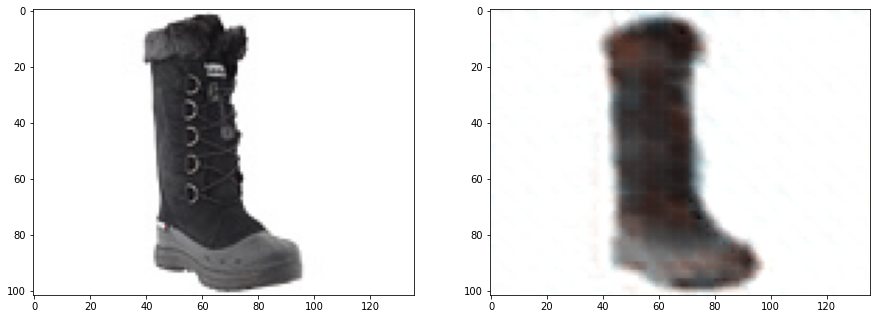

In [ ]:
example_id = random.randint(0, samples.shape[0])
randomized = np.random.normal(samples[example_id], 0.2, samples[0].shape)


with torch.no_grad():
  decoded_randomized = Model.decode(torch.Tensor(samples[example_id]).reshape(1, 16, 6, 8).cuda())  

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].imshow(np.rot90(ds[example_id][0].cpu().numpy().T / 2 + 0.5,k=-1))
axs[1].imshow(np.rot90(decoded_randomized[0].cpu().numpy().T / 2 + 0.5,k=-1))
print('\ndecoded version of original example')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



decoded version of randomized example


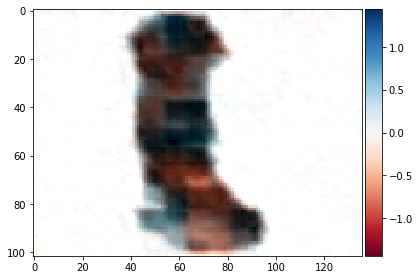

In [ ]:
with torch.no_grad():
  decrand = Model.decode(torch.Tensor(randomized).reshape(1, 16, 6, 8).cuda())
io.imshow(np.rot90(decrand[0].cpu().numpy().T / 2 + 0.5,k=-1))
print('\ndecoded version of randomized example')

In [ ]:
%%time
nearest_ids, nearest_dists = count_distances(np.array([*samples, randomized]), 5)

Adding first batch of 7587 elements


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Recall for the first batch: 0.0 

Saving index to 'first_half.bin'

Loading index from 'first_half.bin'

Adding the second batch of 7588 elements
Recall for two batches: 0.0 

counted cnn
CPU times: user 5.06 s, sys: 97.3 ms, total: 5.15 s
Wall time: 2.75 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [ ]:
print("nearest ids for original example:\t", nearest_ids[example_id])
print("nearest dists for original example:\t", nearest_dists[example_id])
print("nearest ids for randomized example:\t", nearest_ids[-1])
print("nearest dists for randomized example:\t", nearest_dists[-1])

nearest ids for original example:	 [ 936  934 1883  881 1037]
nearest dists for original example:	 [0.        5.2461677 8.985986  9.356414  9.372316 ]
nearest ids for randomized example:	 [15174   936   934  1037   380]
nearest dists for randomized example:	 [ 0.       29.502483 35.230293 38.36606  38.581745]


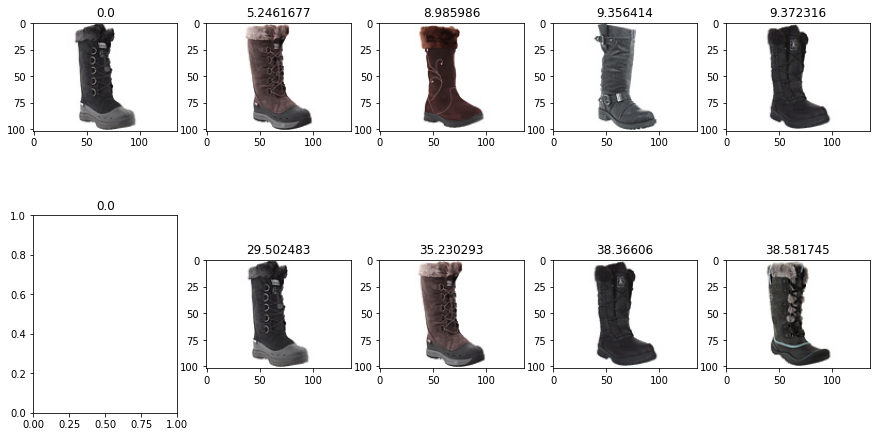

In [ ]:
examples = 2
examples_ids = [example_id,-1]

fig, axs = plt.subplots(examples, nearest_ids.shape[1], figsize=(15,8))

for j in range(examples):
  ex_id = examples_ids[j]
  for i in range(nearest_ids.shape[1]):
      near_id = nearest_ids[ex_id][i]

      if near_id < samples.shape[0]:
        axs[j][i].imshow(np.rot90(ds[near_id][0].numpy().T / 2 + 0.5,k=-1))
      
      axs[j][i].set_title(nearest_dists[ex_id][i])

plt.show()

##4. Обучаем denoising

In [ ]:
class AE3_denoising(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.encoder_seq = nn.Sequential()

        self.encoder_seq.add_module('conv1',
                                    nn.Conv2d(in_channels=3, out_channels=6,
                                              kernel_size=3,
                                              padding=1))
        self.encoder_seq.add_module('bn_conv1', nn.BatchNorm2d(6))
        self.encoder_seq.add_module('conv1_relu', nn.ReLU())
        self.encoder_seq.add_module('pool1',
                                    nn.MaxPool2d(kernel_size=3, stride=3))

        self.encoder_seq.add_module('conv1-5',
                                    nn.Conv2d(in_channels=6, out_channels=6,
                                              kernel_size=2, padding=1))
        self.encoder_seq.add_module('conv1-5_relu', nn.ReLU())

        self.encoder_seq.add_module('conv2',
                                    nn.Conv2d(in_channels=6, out_channels=10,
                                              kernel_size=3,
                                              padding=1))
        self.encoder_seq.add_module('conv2_relu', nn.ReLU())
        self.encoder_seq.add_module('pool2',
                                    nn.MaxPool2d(kernel_size=3, stride=3,
                                                 padding=0))

        self.encoder_seq.add_module('conv2-5',
                                    nn.Conv2d(in_channels=10, out_channels=10,
                                              kernel_size=2, padding=1))
        self.encoder_seq.add_module('conv2-5_relu', nn.ReLU())

        self.encoder_seq.add_module('conv3',
                                    nn.Conv2d(in_channels=10, out_channels=16,
                                              kernel_size=3,
                                              padding=1))
        self.encoder_seq.add_module('bn_conv2', nn.BatchNorm2d(16))
        self.encoder_seq.add_module('conv3_relu', nn.ReLU())
        self.encoder_seq.add_module('pool3',
                                    nn.MaxPool2d(kernel_size=2, stride=2,
                                                 padding=0))

        self.decoder_seq = nn.Sequential()

        self.decoder_seq.add_module('deconv1',
                                    nn.ConvTranspose2d(in_channels=16,
                                                       out_channels=10,
                                                       kernel_size=2, stride=2,
                                                       padding=0))
        self.decoder_seq.add_module('deconv1_relu', nn.ReLU())

        self.decoder_seq.add_module('deconv1-5',
                                    nn.ConvTranspose2d(in_channels=10,
                                                       out_channels=10,
                                                       kernel_size=2,
                                                       padding=0))
        self.decoder_seq.add_module('deconv1-5_relu', nn.ReLU())
        self.decoder_seq.add_module('bn_deconv1', nn.BatchNorm2d(10))

        self.decoder_seq.add_module('deconv2',
                                    nn.ConvTranspose2d(in_channels=10,
                                                       out_channels=6,
                                                       kernel_size=3, stride=3,
                                                       padding=1))  # convolution
        self.decoder_seq.add_module('deconv2_relu', nn.ReLU())

        self.decoder_seq.add_module('deconv2-5',
                                    nn.ConvTranspose2d(in_channels=6,
                                                       out_channels=6,
                                                       kernel_size=2,
                                                       padding=2))
        self.decoder_seq.add_module('deconv2-5_relu', nn.ReLU())
        self.decoder_seq.add_module('bn_deconv2', nn.BatchNorm2d(6))

        self.decoder_seq.add_module('deconv3', nn.ConvTranspose2d(in_channels=6,
                                                                  out_channels=3,
                                                                  kernel_size=3,
                                                                  stride=3,
                                                                  padding=(0,
                                                                           1)))
        
        
        self.alpha = nn.Parameter(torch.FloatTensor([1]))
        self.bias = nn.Parameter(torch.FloatTensor([0]))

    def encode(self, x):
        self.encoded = self.encoder_seq(x)
        return self.encoded

    def decode(self, x):
        self.decoded = self.decoder_seq(x) * self.alpha + self.bias
        return self.decoded

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [ ]:
model = AE3_denoising().cuda()

In [11]:
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
trainset, testset = torch.utils.data.random_split(ds, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False, num_workers=2
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

count_loss = nn.MSELoss()

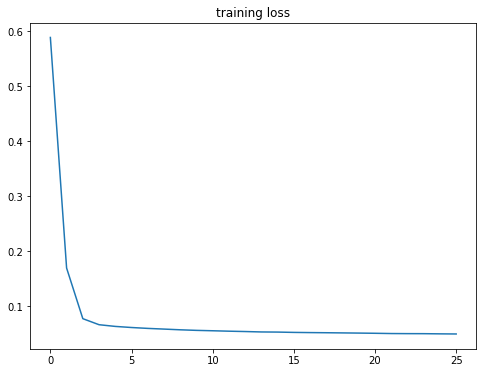

epoch : 26/50, loss = 0.049308
test loss: 0.051889918744564056 (updated 5 epochs ago)


KeyboardInterrupt: ignored

In [ ]:
epochs = 50
test = 20
loss = []

for epoch in range(epochs):
    batchloss = 0
    model.train(True)
    for xbatch, _ in tqdm.notebook.tqdm(trainloader):  

        optimizer.zero_grad()
        noise = (0.1)*torch.randn(xbatch.shape)
        outputs = model((xbatch + noise).cuda())
        train_loss = count_loss(outputs.cuda(), xbatch.cuda())
        train_loss.backward()
        optimizer.step()
        
        batchloss += train_loss.item()
    

    loss.append(batchloss / len(trainloader))

    # test loss
    
    if epoch % test == 0:
      with torch.no_grad():
        model.train(False)
        batchloss = 0
        for testx, testy in testloader:
          testx = testx.to("cuda")

          outputs = model(testx)
          batchloss += count_loss(outputs, testx)
          
        testloss = batchloss / len(testloader)

    # display 

    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))

    fig, axs = plt.subplots(1, 1, figsize=(8, 6))
    clear_output(wait=True)
    axs.plot(loss)
    axs.set_title('training loss')
    plt.show()
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))
    print(f"test loss: {testloss} (updated {epoch % test} epochs ago)")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


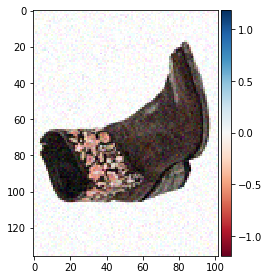

In [ ]:
t = ds[0][0] + 0.1 *torch.randn(ds[0][0].shape) 
io.imshow(t.numpy().T / 2 + 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


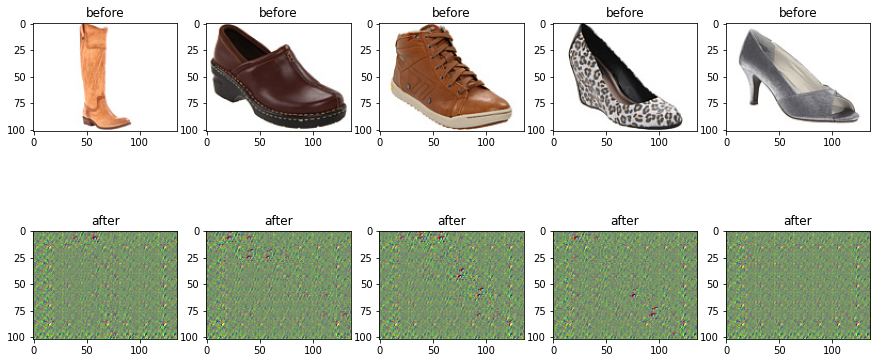

In [ ]:
examples = 5
model.eval()

with torch.no_grad():
  testx = next(iter(trainloader))[0][:examples].to("cuda")

  predicted = model(testx)
  fig, axs = plt.subplots(2, 5, figsize=(15, 7))

  for i in range(examples):
    
    axs[0][i].imshow(np.rot90(testx[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[0][i].set_title('before')
    axs[1][i].imshow(np.rot90(predicted[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[1][i].set_title('after')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


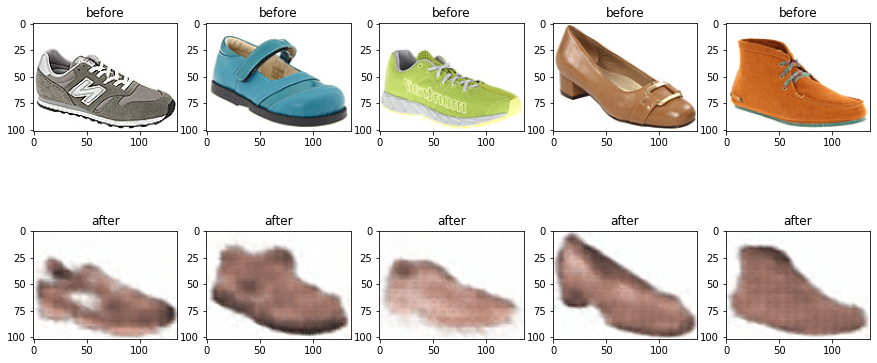

In [19]:
examples = 5
Model.eval()

with torch.no_grad():
  testx = next(iter(trainloader))[0][:examples].to("cuda")

  predicted = Model(testx)
  fig, axs = plt.subplots(2, 5, figsize=(15, 7))

  for i in range(examples):
    
    axs[0][i].imshow(np.rot90(testx[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[0][i].set_title('before')
    axs[1][i].imshow(np.rot90(predicted[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[1][i].set_title('after')
  plt.show()

А так выглядит без денойзинга

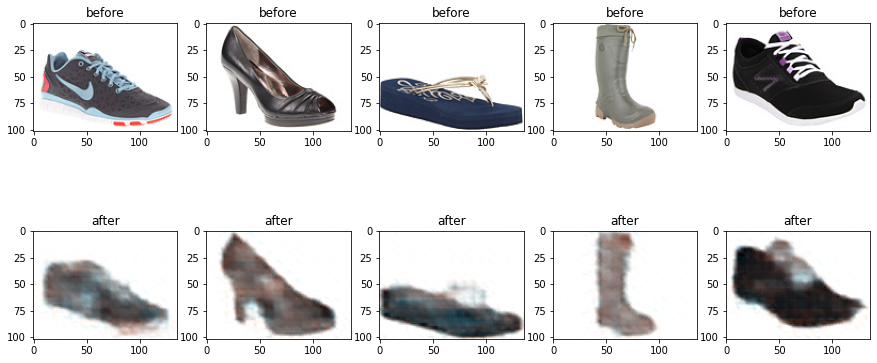

In [ ]:
torch.save(model, 'denoising.pt')

## 5. Ищем похожий (балуемся)

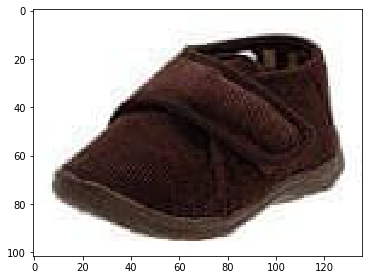

In [ ]:
photo = io.imread('tofind.jpg')
io.imshow(photo)

In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

tr_photo = transform(photo)
tr_photo = torch.stack([tr_photo])
vec = torch.flatten(model.encode(tr_photo.cuda())).cpu()

In [ ]:
h = torch.stack([vec])
h = h.detach().numpy()
print(samples.shape)
samples = np.concatenate((samples, h))
print(samples.shape)
l, d = count_distances(samples, 5)

(15114, 768)
(15115, 768)
Adding first batch of 7557 elements


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Recall for the first batch: 0.0 

Saving index to 'first_half.bin'

Loading index from 'first_half.bin'

Adding the second batch of 7558 elements
Recall for two batches: 0.0 

counted cnn


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


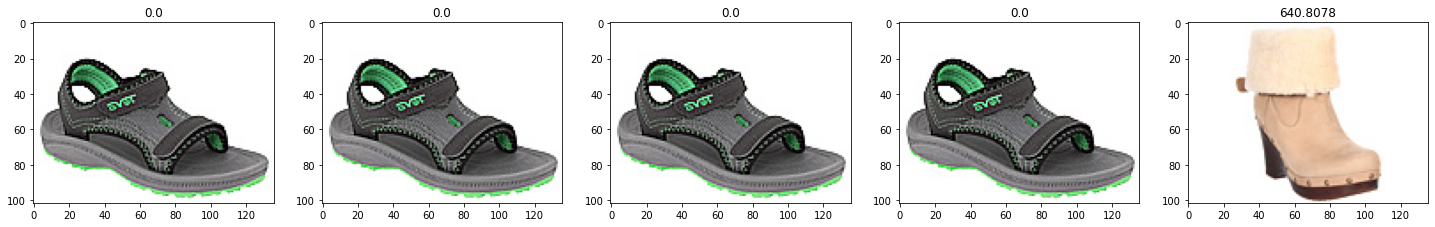

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i in range(l.shape[1]):
  try:
    obj = np.rot90(ds[l[-1][i]][0].to("cpu").numpy().T / 2 + 0.5,k=-1)
  except:
    pass
  axs[i].imshow(obj)
  axs[i].set_title(d[-1][i])
plt.show()